In [1]:
!nvidia-smi

Sat May  7 13:27:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 3070    Off  | 00000000:01:00.0 Off |                  N/A |
| 74%   67C    P2   222W / 240W |   7795MiB /  7979MiB |     99%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import cv2
import numpy as np
import __init_paths
from training.data_loader.dataset_face import FaceDataset
from face_model.gpen_model import FullGenerator, Discriminator
import torch
import itertools
import matplotlib.pyplot as plt

In [2]:
generator = FullGenerator(
    512, 512, 8, channel_multiplier=2, narrow=1, device="cuda", isconcat=False
)#.to("cuda")

In [15]:
d = Discriminator(512)

In [16]:
d.load_state_dict(ckpt["d"])

<All keys matched successfully>

In [17]:
ckpt.keys()

dict_keys(['g_ema', 'latent_avg', 'g', 'd'])

In [5]:
ckpt = torch.load("/root/stylegan2-pytorch/ffhq-512-avg-tpurun1.pt")

In [25]:
torch.save(ckpt, "ffhq-512-avg-tpurun1_rm_noise.pt")

In [8]:
g_ema_dict = ckpt["g_ema"]

In [12]:
len(g_ema_dict.keys())

138

In [13]:
len(generator.generator.state_dict().keys())

138

In [21]:
noise_dict = ["noises.noise_0", "noises.noise_1", "noises.noise_2", "noises.noise_3", "noises.noise_4", "noises.noise_5", "noises.noise_6", "noises.noise_7", "noises.noise_8", "noises.noise_9", "noises.noise_10", "noises.noise_11", "noises.noise_12", "noises.noise_13", "noises.noise_14"]
for i in noise_dict:
    if i in ckpt["g"]:
        del ckpt["g"][i]
    if i in ckpt["g_ema"]:
        del ckpt["g_ema"][i]
#del ckpt["latent_avg"]

In [14]:
generator.generator.load_state_dict(g_ema_dict)

<All keys matched successfully>

In [4]:
ckpt = torch.load("/root/stylegan2-pytorch/ffhq-512-avg-tpurun1.pt")
generator.generator.load_state_dict(ckpt["g_ema"])
del ckpt

RuntimeError: Error(s) in loading state_dict for Generator:
	Unexpected key(s) in state_dict: "noises.noise_0", "noises.noise_1", "noises.noise_2", "noises.noise_3", "noises.noise_4", "noises.noise_5", "noises.noise_6", "noises.noise_7", "noises.noise_8", "noises.noise_9", "noises.noise_10", "noises.noise_11", "noises.noise_12", "noises.noise_13", "noises.noise_14". 

In [8]:
dataset = FaceDataset("images1024x1024", 512)

In [9]:
def tensor2img(img_t, pmax=255.0, imtype=np.uint8):
    img_t = img_t * 0.5 + 0.5
    img_t = img_t.squeeze(0).permute(1, 2, 0).flip(2) # RGB->BGR
    img_np = np.clip(img_t.float().cpu().numpy(), 0, 1) * pmax

    return img_np.astype(imtype)

def showim(img):
    image = tensor2img(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

In [30]:
from training.data_loader.dataset_face import GPEN_degradation

In [32]:
degrader = GPEN_degradation()

In [154]:
degrader.blur_kernel_size = 21
degrader.blur_sigma = [0.1, 10]
degrader.downsample_range = [10, 100]
degrader.noise_range = [0, 25]
degrader.jpeg_range = [5, 50]

In [50]:
dataset.degrader = degrader

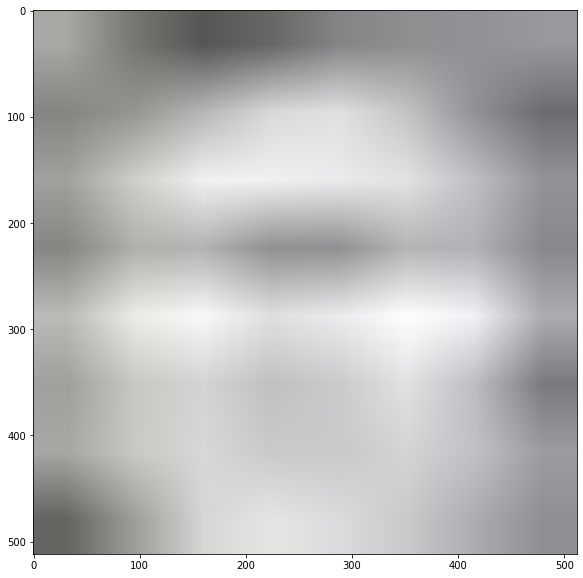

In [169]:
img = dataset[1][0]
showim(img)

In [16]:
with torch.no_grad():
    out, __ = generator(img.reshape(1, 3, 512, 512).to("cuda"))

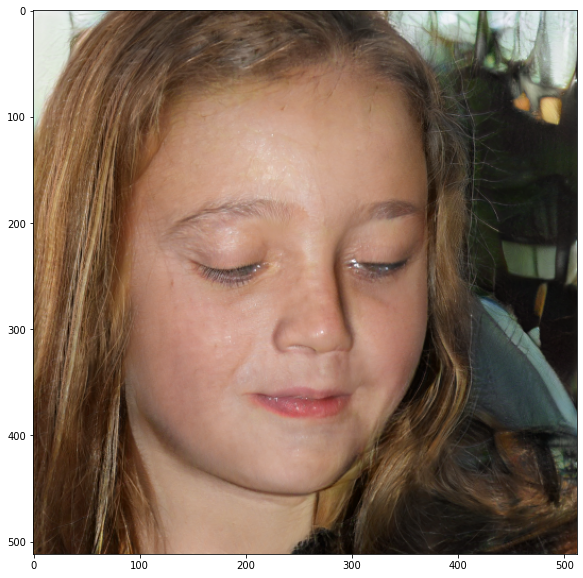

In [17]:
showim(out)

In [11]:
log_size = 9
names = ['ecd%d'%i for i in range(log_size-1)]

In [12]:
with torch.no_grad():
    noise = []
    inputs = img.reshape(1, 3, 512, 512).to("cuda")
    for i in range(log_size-1):
        ecd = getattr(generator, names[i])
        inputs = ecd(inputs)
        noise.append(inputs)
        #print(inputs.shape)
    inputs = inputs.view(inputs.shape[0], -1)
    outs = generator.final_linear(inputs)
torch.cuda.empty_cache()

In [13]:
noise = list(itertools.chain.from_iterable(itertools.repeat(x, 2) for x in noise))[::-1]

In [14]:
noise2 = []
for i in noise:
    noise2.append(torch.randn(i.shape, device="cuda"))

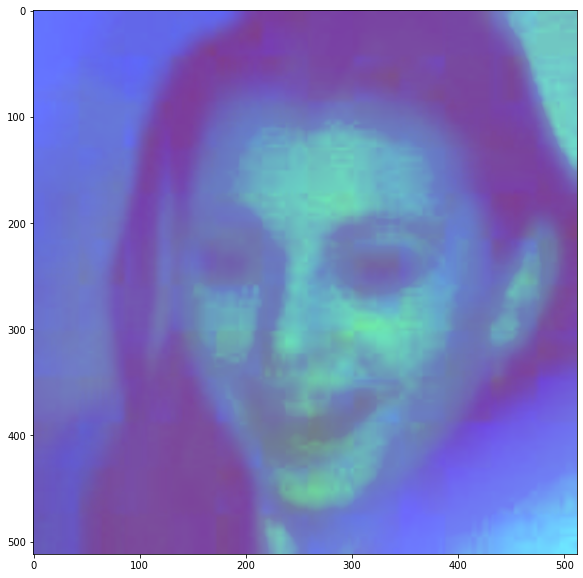

In [38]:
showim(noise[15].view(-1)[:512*512*3].view(1, 3, 512, 512))

In [30]:
noise3 = [0.1*j for i, j in zip(noise, noise2)]

In [22]:
len(noise3)

16

In [31]:
with torch.no_grad():
    res, __ = generator.generator([outs], noise=noise2[1:])

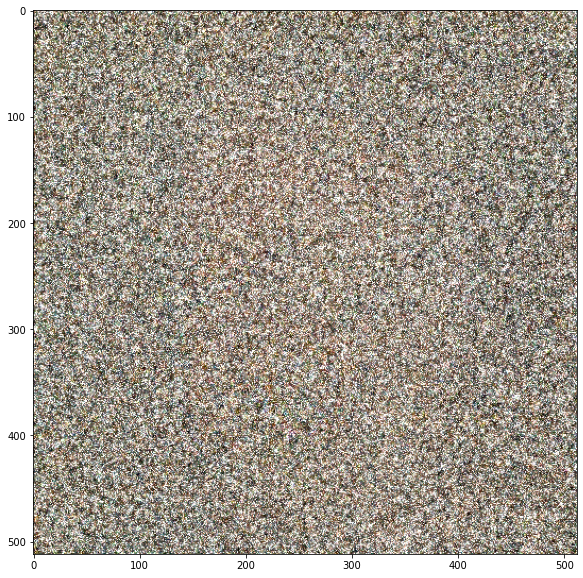

In [32]:
showim(res)